Importamos las librerías necesarias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cornac
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.metrics import Recall, Precision, MAE, RMSE
from cornac.models import ItemKNN, BPR, MF, SVD
from cornac.models import Recommender
from surprise import SVD
from cornac.eval_methods import RatioSplit

Crear modelos propios

In [2]:
class MeanRecommender(Recommender):
    def __init__(self, name="MeanRecommender"):
        super().__init__(name=name)
        self.item_means = None

    def fit(self, train_set, val_set):
        super().fit(train_set, val_set)
        # Calcular la media de las calificaciones para cada ítem
        self.item_means = np.zeros(train_set.num_items)
        for i in range(train_set.num_items):
            ratings = train_set.matrix[:, i].data
            if len(ratings) > 0:
                self.item_means[i] = np.mean(ratings)
            else:
                self.item_means[i] = 0

    def score(self, user_id, item_id=None):
        if item_id is None:
            return self.item_means
        return self.item_means[item_id]
    
class Hybrid(cornac.models.Recommender):
    def __init__(self, mf_model, knn_model, name="Hybrid"):
        super().__init__(name=name)
        self.mf_model = mf_model
        self.knn_model = knn_model

    def fit(self, train_set, eval_set):
        super().fit(train_set,eval_set)
        self.mf_model.fit(train_set, eval_set)
        self.knn_model.fit(train_set, eval_set)

    def score(self, user_idx, item_idx=None, fraction=(10, 1)):
        mf_scores = self.mf_model.score(user_idx, item_idx)
        knn_scores = self.knn_model.score(user_idx, item_idx)
        total = sum(fraction)
        return (mf_scores*fraction[0] + knn_scores*fraction[1])/total


Cargar el dataset de MovieLens 100K

In [3]:
data = movielens.load_feedback()

Definir el método de evaluación

In [4]:
ratio_split = RatioSplit(data=data, test_size=0.2, rating_threshold=4.0, exclude_unknowns=True, verbose=True)

rating_threshold = 4.0
exclude_unknowns = True
---
Training data:
Number of users = 943
Number of items = 1654
Number of ratings = 80000
Max rating = 5.0
Min rating = 1.0
Global mean = 3.5
---
Test data:
Number of users = 943
Number of items = 1654
Number of ratings = 19970
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 943
Total items = 1654


Definir los modelos a emplear

In [5]:
mean_recommender = MeanRecommender() # Modelo propio
mf = MF(k=10, max_iter=25, learning_rate=0.01, lambda_reg=0.02)
svd = cornac.models.SVD()
knn = ItemKNN(k=20, similarity='cosine', name='ItemKNN')
bpr = cornac.models.BPR(k=10, max_iter=25, learning_rate=0.01, lambda_reg=0.02)
hybrid = Hybrid(mf_model=mf, knn_model=knn)


Definir las metricas a utilizar

In [6]:
metrics = []
metrics.append(MAE())
metrics.append(RMSE())
metrics.append(Recall(10))
metrics.append(Precision(10))

Definir el experimento


In [7]:
experiment = cornac.Experiment(eval_method=ratio_split, models=[mean_recommender, mf, bpr, svd, knn, hybrid], metrics=metrics)

Ejecutar el experimento

In [8]:
experiment.run()


[MeanRecommender] Training started!

[MeanRecommender] Evaluation started!


Rating:   0%|          | 0/19970 [00:00<?, ?it/s]

Ranking:   0%|          | 0/942 [00:00<?, ?it/s]


[MF] Training started!

[MF] Evaluation started!


Rating:   0%|          | 0/19970 [00:00<?, ?it/s]

Ranking:   0%|          | 0/942 [00:00<?, ?it/s]


[BPR] Training started!

[BPR] Evaluation started!


Rating:   0%|          | 0/19970 [00:00<?, ?it/s]

Ranking:   0%|          | 0/942 [00:00<?, ?it/s]


[SVD] Training started!

[SVD] Evaluation started!


Rating:   0%|          | 0/19970 [00:00<?, ?it/s]

Ranking:   0%|          | 0/942 [00:00<?, ?it/s]


[ItemKNN] Training started!


  0%|          | 0/1654 [00:00<?, ?it/s]


[ItemKNN] Evaluation started!


Rating:   0%|          | 0/19970 [00:00<?, ?it/s]

Ranking:   0%|          | 0/942 [00:00<?, ?it/s]


[Hybrid] Training started!


/usr/local/lib/python3.12/dist-packages/cornac/models/recommender.py:322: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(


  0%|          | 0/1654 [00:00<?, ?it/s]


[Hybrid] Evaluation started!


Rating:   0%|          | 0/19970 [00:00<?, ?it/s]

Ranking:   0%|          | 0/942 [00:00<?, ?it/s]


TEST:
...
                |    MAE |   RMSE | Precision@10 | Recall@10 | Train (s) | Test (s)
--------------- + ------ + ------ + ------------ + --------- + --------- + --------
MeanRecommender | 0.8175 | 0.9820 |       0.0002 |    0.0002 |    0.6872 |   1.4880
MF              | 0.7339 | 0.8943 |       0.0782 |    0.0531 |    0.1129 |   6.8575
BPR             | 2.1626 | 2.3577 |       0.1173 |    0.1156 |    0.7527 |   4.4081
SVD             | 0.7428 | 0.9031 |       0.0708 |    0.0511 |    0.0829 |   3.0095
ItemKNN         | 0.8180 | 0.9925 |       0.0246 |    0.0146 |    0.3650 |  14.6052
Hybrid          | 0.7392 | 0.9083 |       0.0696 |    0.0552 |    0.6017 |  16.6601



Extraer los resultados de las métricas

In [9]:
results = experiment.result
mean_mae = results[0].metric_avg_results['MAE']
mean_rmse = results[0].metric_avg_results['RMSE']
mean_precision = results[0].metric_avg_results['Precision@10']
mf_mae = results[1].metric_avg_results['MAE']
mf_rmse = results[1].metric_avg_results['RMSE']
mf_precision = results[1].metric_avg_results['Precision@10']
bpr_mae = results[2].metric_avg_results['MAE']
bpr_rmse = results[2].metric_avg_results['RMSE']
bpr_precision = results[2].metric_avg_results['Precision@10']
svd_mae = results[3].metric_avg_results['MAE']
svd_rmse = results[3].metric_avg_results['RMSE']
svd_precision = results[3].metric_avg_results['Precision@10']
knn_mae = results[4].metric_avg_results['MAE']
knn_rmse = results[4].metric_avg_results['RMSE']
knn_precision = results[4].metric_avg_results['Precision@10']

Crear un gráfico de barras para mostrar los resultados

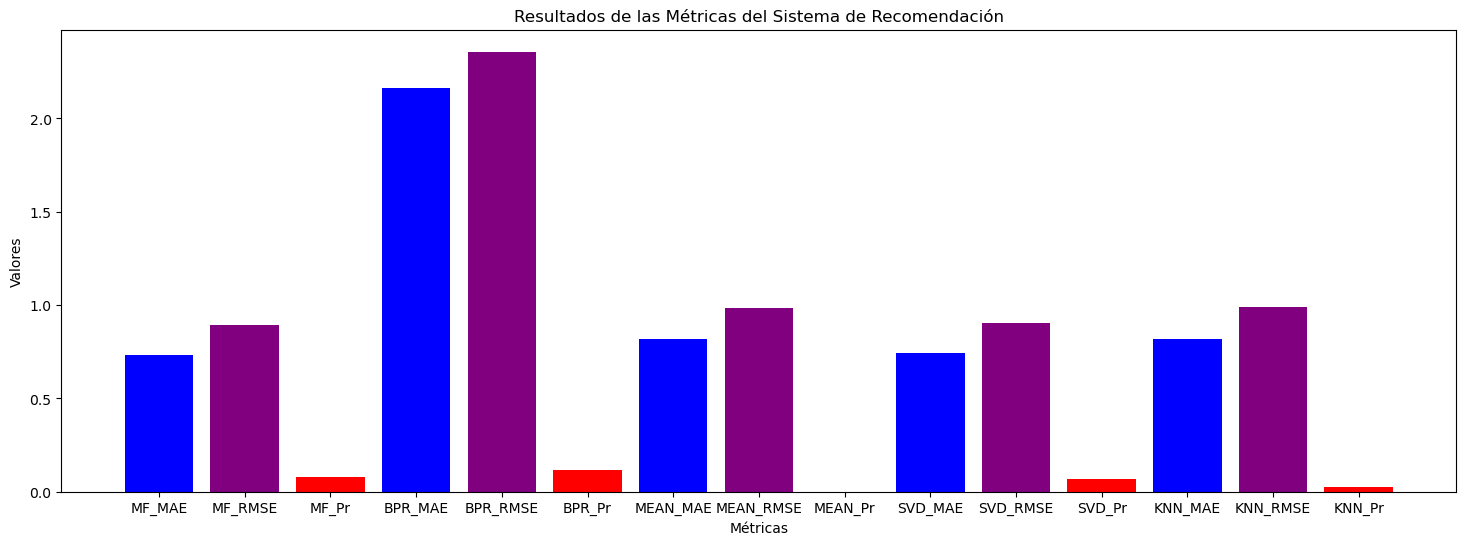

In [10]:
metrics_names = ['MF_MAE', 'MF_RMSE', 'MF_Pr', 'BPR_MAE', 'BPR_RMSE', 'BPR_Pr', 'MEAN_MAE', 'MEAN_RMSE', 'MEAN_Pr', 'SVD_MAE', 'SVD_RMSE', 'SVD_Pr', 'KNN_MAE', 'KNN_RMSE', 'KNN_Pr']
values = [mf_mae, mf_rmse, mf_precision, bpr_mae, bpr_rmse, bpr_precision, mean_mae, mean_rmse, mean_precision, svd_mae, svd_rmse, svd_precision, knn_mae, knn_rmse, knn_precision] 

plt.figure(figsize=(18, 6))
plt.bar(metrics_names, values, color=['blue', 'purple', 'red', 'blue', 'purple', 'red', 'blue', 'purple', 'red', 'blue', 'purple', 'red', 'blue', 'purple', 'red'])
plt.xlabel('Métricas')
plt.ylabel('Valores')
plt.title('Resultados de las Métricas del Sistema de Recomendación')
plt.show()
